In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/handwritten-mathematical-expressions/MatricesTest2014/RIT_MatrixTest_2014_82.inkml
/kaggle/input/handwritten-mathematical-expressions/MatricesTest2014/RIT_MatrixTest_2014_39.inkml
/kaggle/input/handwritten-mathematical-expressions/MatricesTest2014/RIT_MatrixTest_2014_63.inkml
/kaggle/input/handwritten-mathematical-expressions/MatricesTest2014/RIT_MatrixTest_2014_116.inkml
/kaggle/input/handwritten-mathematical-expressions/MatricesTest2014/RIT_MatrixTest_2014_89.inkml
/kaggle/input/handwritten-mathematical-expressions/MatricesTest2014/RIT_MatrixTest_2014_30.inkml
/kaggle/input/handwritten-mathematical-expressions/MatricesTest2014/RIT_MatrixTest_2014_50.inkml
/kaggle/input/handwritten-mathematical-expressions/MatricesTest2014/RIT_MatrixTest_2014_71.inkml
/kaggle/input/handwritten-mathematical-expressions/MatricesTest2014/RIT_MatrixTest_2014_107.inkml
/kaggle/input/handwritten-mathematical-expressions/MatricesTest2014/RIT_MatrixTest_2014_103.inkml
/kaggle/input/handwritten-m

## Importing Necessary Libraries

In [2]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50V2 as ResNet
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 28)

import random
import os

!pip install imutils
import imutils
from imutils.contours import sort_contours

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=2cdcd072a6ccd0baf7961602e9f41eb03454e0d0c92e8bc7e7c901bd2acfc7ed
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [3]:
def extractImages(datadir):
    # Get the data
    imagesData = []
    imagesLabel = []
    for folder in os.listdir(datadir):
        path = os.path.join(datadir, folder)
        for images in os.listdir(path):
            img = cv2.imread(os.path.join(path, images), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (32, 32))
            imagesData.append(img)
            imagesLabel.append(folder)
            
    # Shuffle data
    combined = list(zip(imagesData, imagesLabel))
    random.shuffle(combined)
    imagesData, imagesLabel = zip(*combined)
    
    return (imagesData, imagesLabel)

This code defines a function, `extractImages`, that processes images from a directory for use in machine learning. It performs the following steps:

1. **Parameters**:
   - `datadir`: The path to the directory where image data is stored. Each subfolder in `datadir` is expected to represent a class label and contain images for that class.

2. **Initialize Lists**:
   - `imagesData`: Stores the processed images.
   - `imagesLabel`: Stores the label (or class) for each image.

3. **Loop through Subfolders (Classes)**:
   - `for folder in os.listdir(datadir)`: Iterates through each folder in `datadir`, with each folder representing a unique class.
   - `path = os.path.join(datadir, folder)`: Constructs the full path to each class folder.

4. **Loop through Images in Each Folder**:
   - For each image in the folder:
     - `img = cv2.imread(os.path.join(path, images), cv2.IMREAD_GRAYSCALE)`: Reads the image in grayscale using OpenCV’s `cv2.imread()`.
     - `img = cv2.resize(img, (32, 32))`: Resizes the image to 32x32 pixels, ensuring consistent input size for the model.
     - `imagesData.append(img)`: Adds the resized grayscale image to `imagesData`.
     - `imagesLabel.append(folder)`: Adds the folder name (class label) to `imagesLabel`, associating the image with its class.

5. **Shuffle Data**:
   - `combined = list(zip(imagesData, imagesLabel))`: Combines `imagesData` and `imagesLabel` into pairs.
   - `random.shuffle(combined)`: Shuffles the list to randomize the order of images and labels, which helps avoid biases during training.
   - `imagesData, imagesLabel = zip(*combined)`: Unzips the shuffled data back into `imagesData` and `imagesLabel` lists.

6. **Return Processed Data**:
   - `return (imagesData, imagesLabel)`: Returns two tuples containing the images and their corresponding labels.

### Summary
The function reads, resizes, labels, and shuffles images from folders in a directory structure and outputs them as lists of image data and labels. This function is commonly used to preprocess image data for training or testing machine learning models.

In [4]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
!unzip -qo data.zip

--2024-11-12 14:42:22--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.156.187, 52.219.160.207, 52.219.156.31, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.156.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28437489 (27M) [application/x-zip-compressed]
Saving to: 'data.zip'

data.zip            100%[===================>]  27.12M  12.2MB/s    in 2.2s    

2024-11-12 14:42:25 (12.2 MB/s) - 'data.zip' saved [28437489/28437489]



## Importing Dataset

In [5]:
# Import train data
imagesData = []
imagesLabel = []
train_data_dir = '/kaggle/working/data/dataset'

imagesData, imagesLabel = extractImages(train_data_dir)

print("number of image: ",len(imagesData))        
print("shape of image:  ",imagesData[1].shape)
print("labels:          ",list(set(imagesLabel)))

number of image:  7600
shape of image:   (32, 32)
labels:           ['1', '9', '6', '5', '8', '0', 'mul', 'sub', '3', '2', 'div', '4', 'add', '7']


This code loads and inspects training images from a specified directory:

1. **Initialize Lists**: `imagesData` and `imagesLabel` are empty lists to store image data and labels.

2. **Set Data Directory**: `train_data_dir` is defined as the path where images are stored.

3. **Load Data**: `extractImages(train_data_dir)` is called to load, resize, and label images, storing results in `imagesData` and `imagesLabel`.

4. **Print Dataset Info**:
   - `len(imagesData)`: Prints total number of images.
   - `imagesData[1].shape`: Prints shape of a sample image, expected to be `(32, 32)`.
   - `list(set(imagesLabel))`: Prints unique labels (classes).

## Train Test Split

In [6]:
imagesTrainData, imagesTestData, imagesTrainLabel, imagesTestLabel = train_test_split(imagesData,imagesLabel, shuffle=True, test_size=0.2, random_state=42, stratify= imagesLabel )

## Visualisation

In [7]:
def showImage (images,label,part):
    figure = plt.figure(figsize=((len(part)/10 + 1)*10, (len(part)/10 + 1)*2))
    j = 0
    for i in part:
        lbl = label[i]
        img = images[i]
        img = cv2.resize(img, (256, 256))
        figure.add_subplot(int(len(part)/10)+1, 10, j+1)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(lbl)
        j += 1

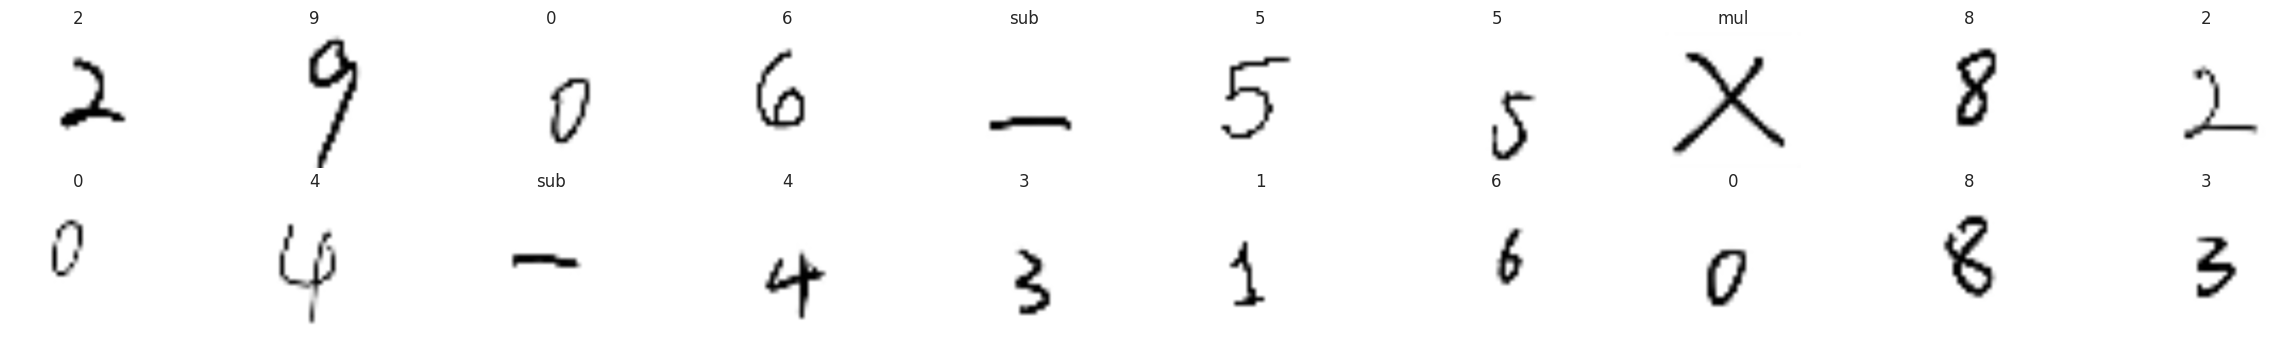

In [8]:
showImage(imagesTrainData,imagesTrainLabel, range(20))


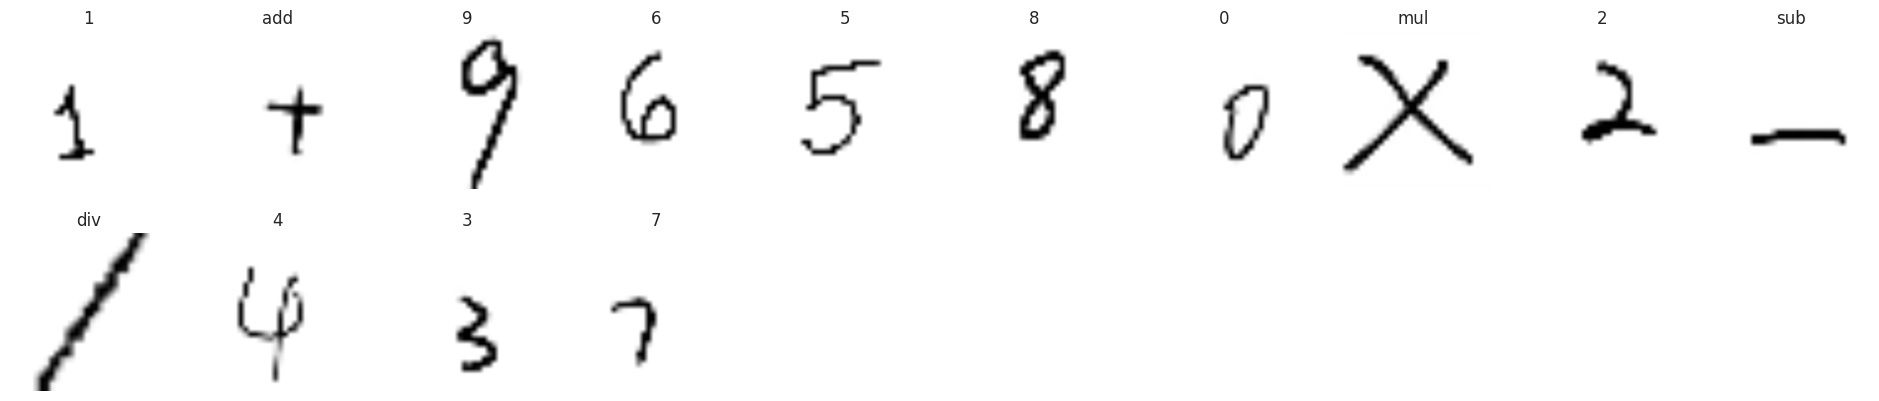

In [9]:
unique_idx = [imagesTrainLabel.index(i) for i in list(set(imagesTrainLabel))]
showImage(imagesTrainData,imagesTrainLabel, unique_idx )

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


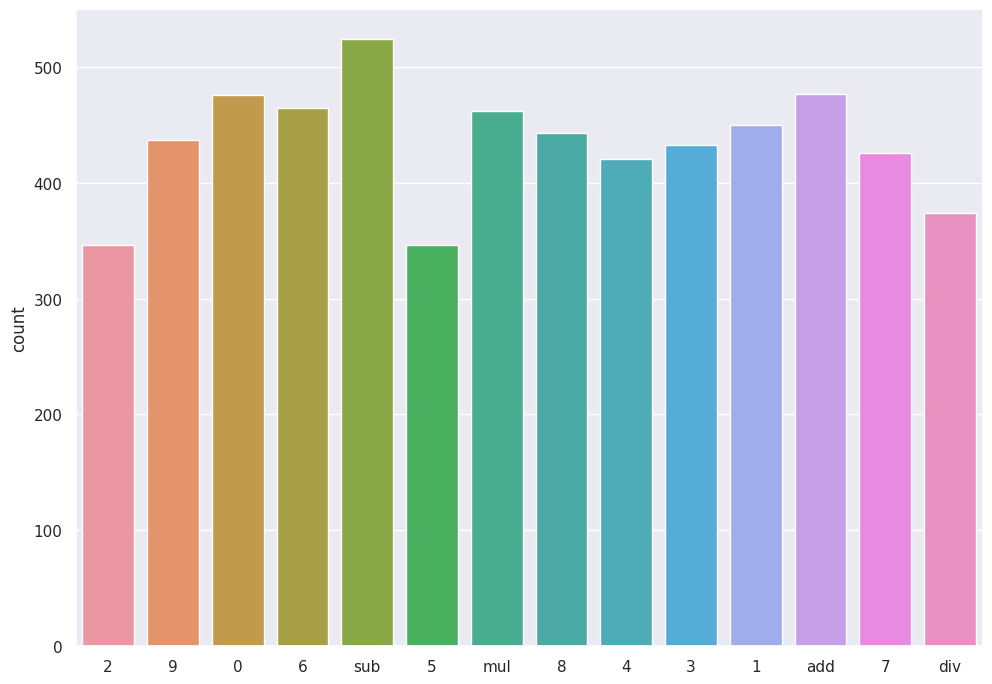

In [10]:
sns.countplot(x= list(imagesTrainLabel));

## Label Encoding

In [11]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(imagesTrainLabel)
Y_test = label_encoder.transform(imagesTestLabel)

This code encodes categorical labels into integers:

1. **Initialize Encoder**: `LabelEncoder()` converts labels to numeric values.
2. **Encode Training Labels**: `fit_transform()` learns unique labels in `imagesTrainLabel` and transforms them into integers as `Y_train`.
3. **Encode Test Labels**: `transform()` applies the same encoding to `imagesTestLabel`, producing `Y_test`.

This prepares `Y_train` and `Y_test` as numeric labels for model training and testing.

In [12]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [13]:
X_train = np.array(imagesTrainData)
X_test = np.array(imagesTestData)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [14]:
X_train[0].shape

(32, 32, 1)

## Model Building

In [15]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

This code defines a CNN model for recognizing math symbols and digits:

1. **Input Layer**: Accepts 32x32 grayscale images (`input_shape=(32, 32, 1)`).

2. **Convolutional Layers**:
   - Three Conv2D layers (32, 32, and 64 filters, each 3x3) with ReLU activations and L2 regularization, followed by MaxPooling layers to reduce spatial dimensions.

3. **Fully Connected Layers**:
   - Flattened output passes through two Dense layers (120 and 84 units) with ReLU activations, and one output Dense layer (14 units with softmax) for classification into 14 classes.

4. **Dropout**: Adds dropout (0.5) after flattening to reduce overfitting.

5. **Compilation**: Uses Adam optimizer and categorical cross-entropy loss, with accuracy as the evaluation metric.

The function returns the compiled model.

In [16]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act1 (Activation)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act2 (Activation)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act3 (Activation)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 120)            │       123,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 14)             │         1,190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,418 (634.45 KB)

 Trainable params: 162,418 (634.45 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
aug = ImageDataGenerator(zoom_range=0.1,
#                          rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.0909 - loss: 996.9995 - val_accuracy: 0.2178 - val_loss: 119.1598
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.2085 - loss: 82.6527 - val_accuracy: 0.1868 - val_loss: 83.5911
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.2094 - loss: 60.2152 - val_accuracy: 0.2520 - val_loss: 66.4938
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.3704 - loss: 46.6549 - val_accuracy: 0.3586 - val_loss: 53.7533
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.4607 - loss: 37.0495 - val_accuracy: 0.3987 - val_loss: 44.3781
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.4557 - loss: 29.9798 - val_accuracy: 0.4474 - val_loss: 37.3119
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.5199 - loss: 24.6624 - val_accuracy: 0.4914 - val_loss: 31.8290
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.5596 - loss: 20.5988 - 

In [18]:
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=50, validation_data=(X_test, Y_test))

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9245 - loss: 0.4874 - val_accuracy: 0.9105 - val_loss: 0.6893
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9396 - loss: 0.4134 - val_accuracy: 0.9112 - val_loss: 0.6519
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9246 - loss: 0.4428 - val_accuracy: 0.9612 - val_loss: 0.5404
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9335 - loss: 0.4247 - val_accuracy: 0.8993 - val_loss: 0.6650
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.9280 - loss: 0.4486 - val_accuracy: 0.9500 - val_loss: 0.5201
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9331 - loss: 0.4362 - val_accuracy: 0.9421 - val_loss: 0.5894
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.9326 - loss: 0.4482 - val_accuracy: 0.9322 - val_loss: 0.5729
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9429 - loss: 0.3871 - val_accuracy: 

This code uses Keras' `ImageDataGenerator` for real-time data augmentation (zoom, width/height shifts) to train a model. It generates augmented batches from `X_train` and `Y_train` with a batch size of 128. The model trains for 100 epochs and evaluates on `X_test` and `Y_test` after each epoch. The augmentation helps prevent overfitting and improves generalization.

## Model Evaluation 

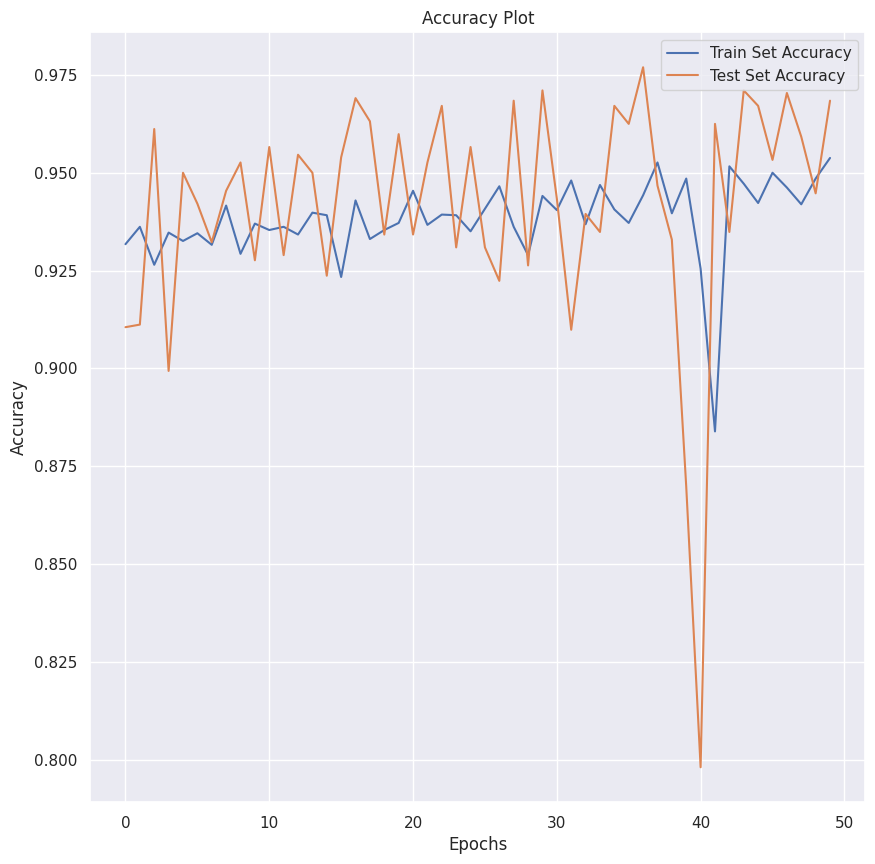

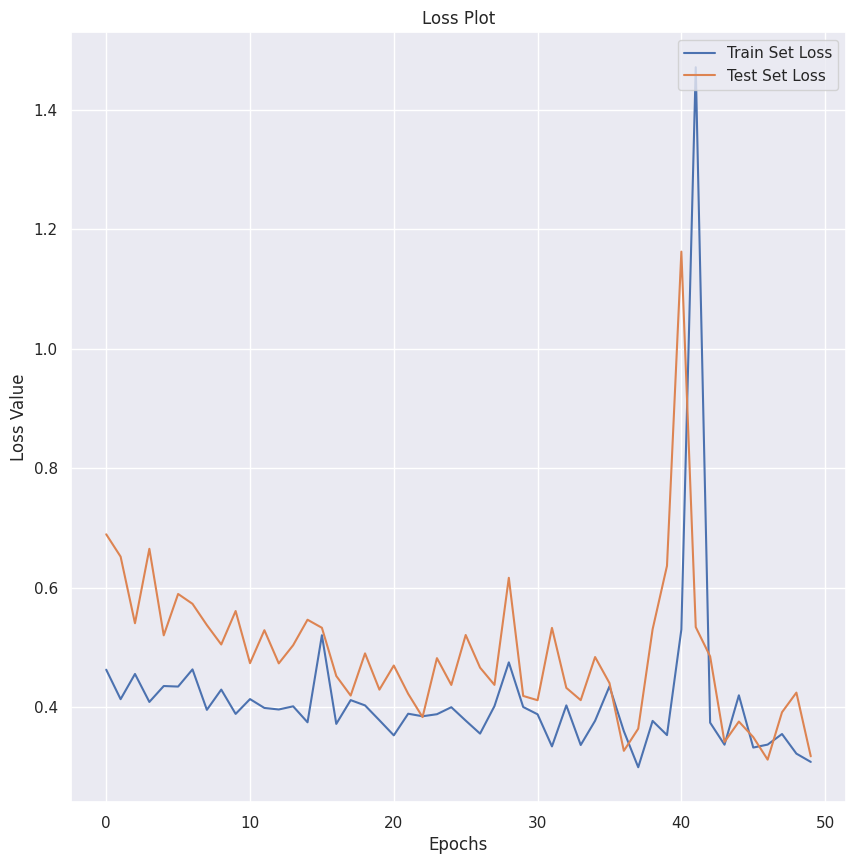

In [19]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

This code generates two plots using Matplotlib to visualize the training process:

1. **Accuracy Plot**:
   - Plots the training (`accuracy`) and validation (`val_accuracy`) accuracy over epochs.
   - Displays the model's performance on both the training and test sets.
   - Labels the axes and adds a legend.

2. **Loss Plot**:
   - Plots the training (`loss`) and validation (`val_loss`) loss over epochs.
   - Shows how the loss decreases during training for both training and test sets.
   - Labels the axes and adds a legend.

Each plot helps track model performance during training.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


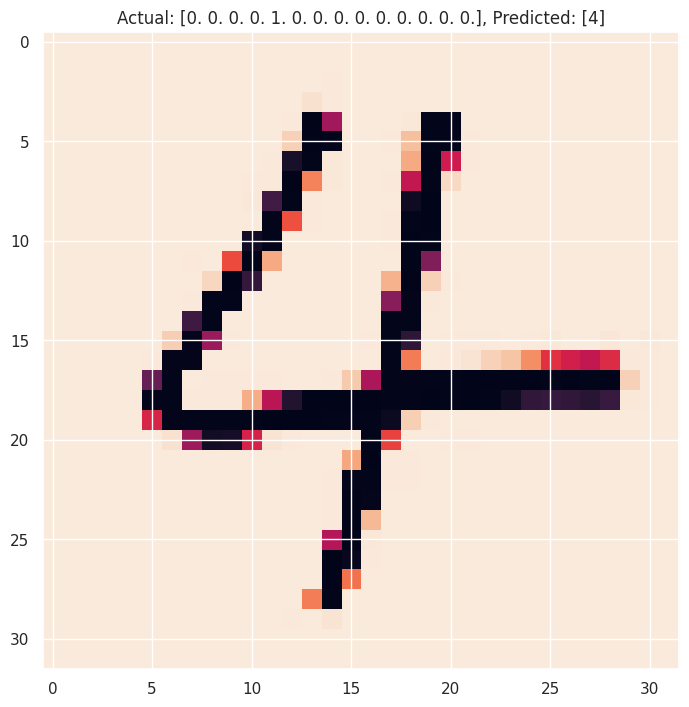

Actual Label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Label: [4]


In [20]:
# Select a single sample from the test dataset
sample_index = 0  # Choose the index of the sample (e.g., first sample)
sample_image = X_test[sample_index]
actual_label = Y_test[sample_index]

# Reshape or preprocess the sample if needed (depending on model input requirements)
# For example, ensure the image is 4D: (1, height, width, channels)
sample_image = np.expand_dims(sample_image, axis=0)

# Get the model's prediction for the sample
prediction = model.predict(sample_image)

# Convert prediction to label (if necessary)
predicted_label = np.argmax(prediction, axis=1)

# Display the sample and prediction
plt.imshow(X_test[sample_index])  # Show the image
plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
plt.show()

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {predicted_label}")


In [21]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       119
           1       1.00      0.92      0.96       112
           2       0.98      0.95      0.97        87
           3       0.95      0.94      0.95       108
           4       0.95      0.95      0.95       105
           5       0.99      0.93      0.96        87
           6       0.96      0.95      0.95       116
           7       0.95      0.99      0.97       107
           8       0.92      0.97      0.95       111
           9       0.92      1.00      0.96       109
          10       1.00      0.97      0.99       119
          11       1.00      1.00      1.00        94
          12       1.00      0.99      1.00       115
          13       1.00      1.00      1.00       131

    accuracy                           0.97      1520
   macro avg       0.97      0.97      0.97      1520
weighted avg       0.97      0.97      0.

## Saving the Model

In [22]:
model.save('model.h5')